In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

In [83]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0116/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 145.88it/s]

Now all merge samples are saved!


In [84]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(2760, 1, 2)
(690, 1, 2)


In [85]:
kernel=9
bands=40
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [86]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [87]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (2760, 3240)


In [88]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (690, 3240)


In [89]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [90]:
y_pred_rf = rf_classifier.predict(X_val_rf)

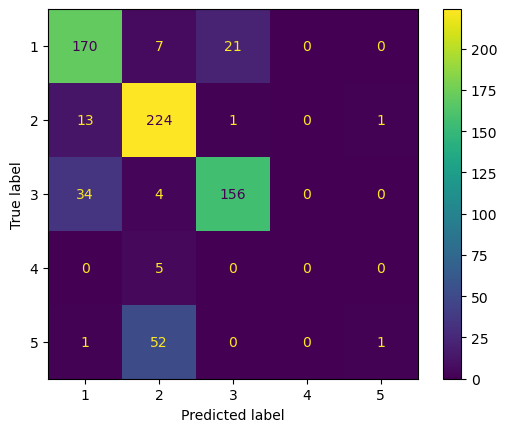

Accuracy Random Forest Classifier:  0.7985507246376812


In [91]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [92]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2760, 81, 40)


In [93]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (690, 81, 40)


In [94]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(kernel*kernel,bands)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [96]:
history = simple_model.fit(X_train_nn, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=50)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/200


2023-01-16 04:39:56.693236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 1s 12ms/sample - loss: 1.0430 - accuracy: 0.5960 - val_loss: 0.8594 - val_accuracy: 0.6348


2023-01-16 04:39:57.457818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 51/200
87/87 [==============================] - 0s 6ms/sample - loss: 0.5029 - accuracy: 0.8007 - val_loss: 0.5851 - val_accuracy: 0.7957
Epoch 101/200
87/87 [==============================] - 0s 6ms/sample - loss: 0.4285 - accuracy: 0.8304 - val_loss: 0.6099 - val_accuracy: 0.7739
Epoch 151/200
87/87 [==============================] - 0s 6ms/sample - loss: 0.3700 - accuracy: 0.8565 - val_loss: 0.6555 - val_accuracy: 0.7812


In [97]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

22/22 [==============================] - 0s 3ms/step
Prediction example:  [4.2154786e-13 9.7002351e-01 8.5903490e-03 1.9744702e-02 3.9063659e-07
 1.6410677e-03 4.5049712e-13 1.4909703e-12 2.6346709e-13 1.0429544e-12
 4.8464536e-13 4.1397371e-13 1.2434247e-12 6.6450778e-13 9.8275684e-13
 9.8464780e-13]  Class:  1


2023-01-16 04:41:43.166261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


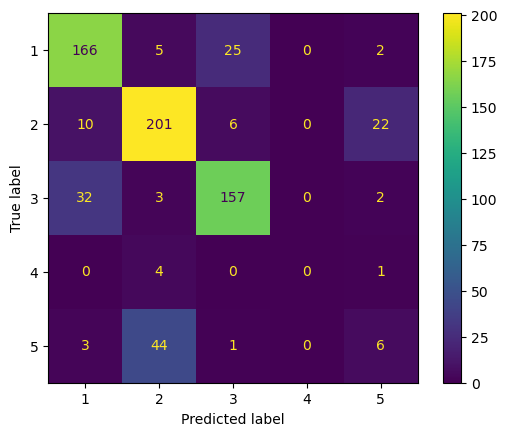

Accuracy Simple Deep Learning model:  0.7681159420289855


In [98]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

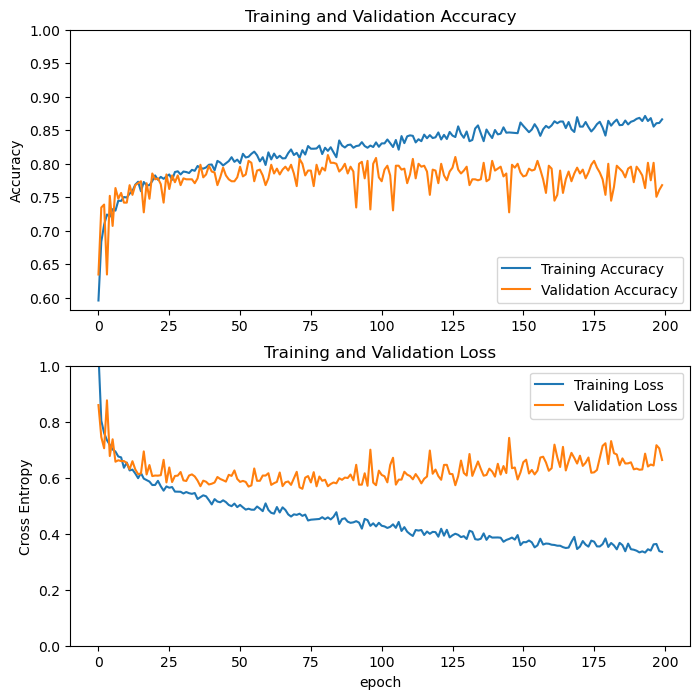

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [100]:
fine_tune_epochs = 200
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 200/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3311 - accuracy: 0.8641 - val_loss: 0.6547 - val_accuracy: 0.7884
Epoch 201/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3263 - accuracy: 0.8699 - val_loss: 0.6573 - val_accuracy: 0.7841
Epoch 202/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3437 - accuracy: 0.8594 - val_loss: 0.6819 - val_accuracy: 0.7971
Epoch 203/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3249 - accuracy: 0.8681 - val_loss: 0.6840 - val_accuracy: 0.7812
Epoch 204/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3300 - accuracy: 0.8685 - val_loss: 0.6768 - val_accuracy: 0.7870
Epoch 205/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3073 - accuracy: 0.8815 - val_loss: 0.6936 - val_accuracy: 0.7739
Epoch 206/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3378 - accuracy: 0.8649 - val_loss: 0.6870 - val_accuracy: 0.7783

In [101]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

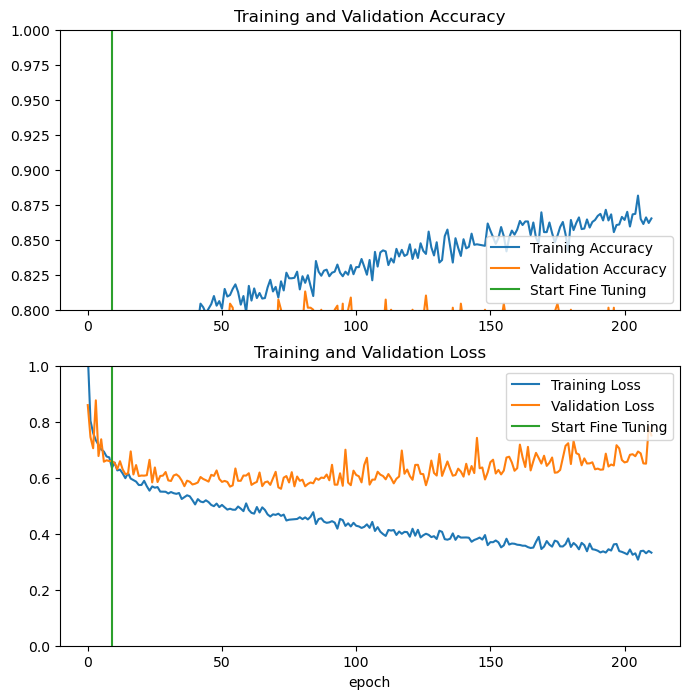

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [103]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 5ms/step - loss: 0.7510 - accuracy: 0.7884
Test accuracy : 0.7884058356285095


In [104]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [105]:

model.summary() 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dense_16 (Dense)            (None, 64)               

In [106]:

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16))

In [107]:

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 20, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dense_16 (Dense)            (None, 64)               

In [108]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/100


2023-01-16 04:42:34.388870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-16 04:42:36.356262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 28ms/sample - loss: 1.2407 - accuracy: 0.4641 - val_loss: 0.8146 - val_accuracy: 0.6377
Epoch 21/100
87/87 [==============================] - 2s 20ms/sample - loss: 0.4559 - accuracy: 0.8236 - val_loss: 0.5626 - val_accuracy: 0.7899
Epoch 41/100
87/87 [==============================] - 2s 18ms/sample - loss: 0.3327 - accuracy: 0.8699 - val_loss: 0.6173 - val_accuracy: 0.7986
Epoch 61/100
87/87 [==============================] - 2s 18ms/sample - loss: 0.1942 - accuracy: 0.9236 - val_loss: 1.0004 - val_accuracy: 0.7884
Epoch 81/100
87/87 [==============================] - 2s 20ms/sample - loss: 0.0434 - accuracy: 0.9859 - val_loss: 1.7272 - val_accuracy: 0.7594


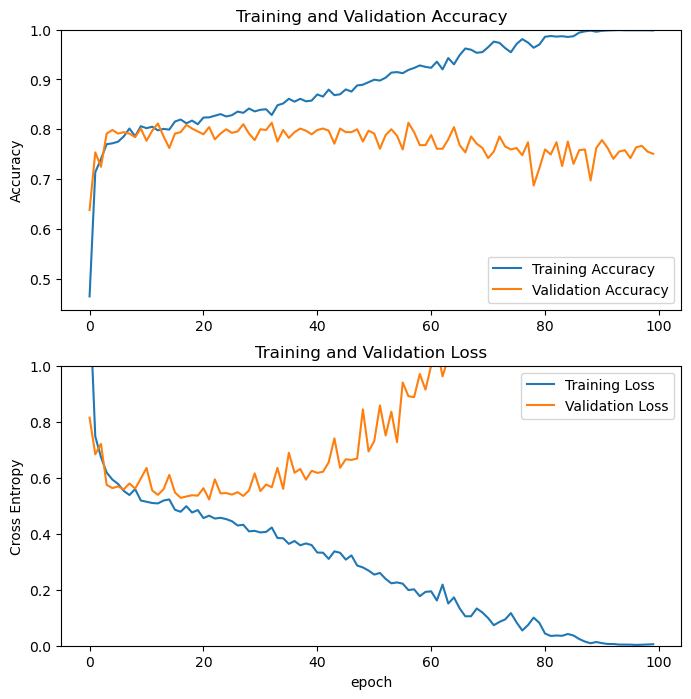

In [109]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [110]:
y_pred_cnn_p = model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

11/22 [==============>...............] - ETA: 0s

2023-01-16 04:45:56.864399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 11ms/step
Prediction example:  [-39.05092   12.521509  -4.120864  -4.969911 -37.877254 -12.436986
 -41.861027 -43.415813 -44.21156  -45.556515 -44.093437 -40.20529
 -42.07784  -44.81037  -44.205612 -43.885235]  Class:  1


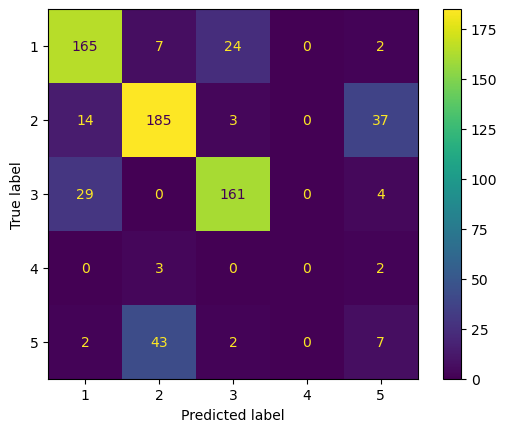

Accuracy Simple Deep Learning model:  0.7507246376811594


In [111]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)